In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, plot_tree
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
import pandas as pd
import numpy as np

from feature_importance_techniques import *

In [2]:
FREQ = "1D"

In [3]:
def get_test_data(
    n_features=40, n_informative=10, n_redundant=10, n_samples=10000, n_classes=2, weights=[0.5, 0.5], shuffle=True
):
    # generate a random dataset for a classification problem
    from sklearn.datasets import make_classification

    trnsX, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        shuffle=shuffle,
        n_classes=n_classes,
        weights=weights,
    )
    df = pd.date_range(periods=n_samples, end=pd.datetime.today(), freq=FREQ)
    df0 = pd.DatetimeIndex(df)
    trnsX, y = pd.DataFrame(trnsX, index=df0), pd.Series(y, index=df0)
    df0 = ["I_" + str(i) for i in range(n_informative)] + ["R_" + str(i) for i in range(n_redundant)]
    df0 += ["N_" + str(i) for i in range(n_features - len(df0))]
    trnsX.columns = df0

    return trnsX, y

In [4]:
X, y = get_test_data(12, 4, 6, n_samples=1000)

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [5]:
clf = LGBMClassifier()
cv = StratifiedKFold(n_splits=10)
scores = cv_score(clf, X, y, f1_score, cv)

FOLD: 1 SCORE: 0.9504950495049505
FOLD: 2 SCORE: 0.9696969696969697
FOLD: 3 SCORE: 0.9387755102040817
FOLD: 4 SCORE: 0.96
FOLD: 5 SCORE: 0.9423076923076924
FOLD: 6 SCORE: 0.9696969696969697
FOLD: 7 SCORE: 0.9607843137254902
FOLD: 8 SCORE: 0.92
FOLD: 9 SCORE: 0.9263157894736842
FOLD: 10 SCORE: 0.9411764705882353


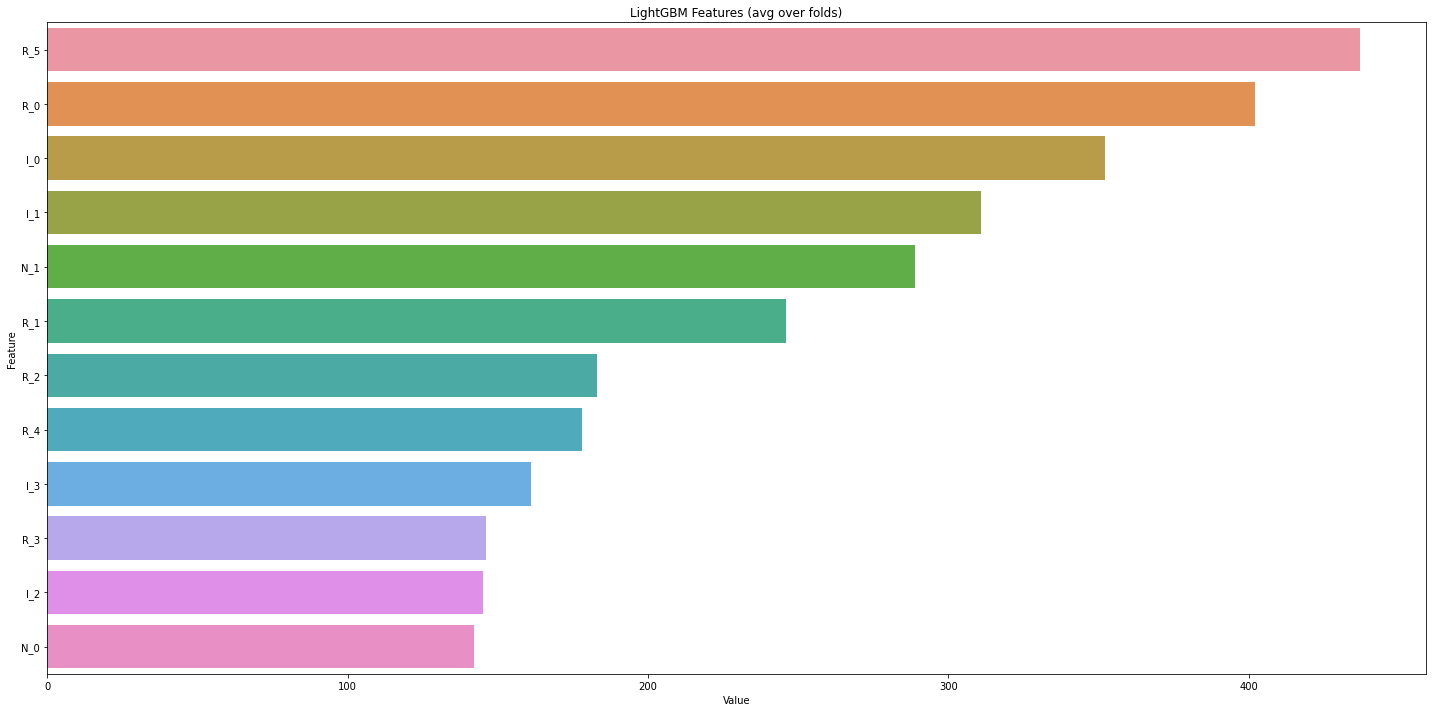

<Figure size 432x288 with 0 Axes>

In [6]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances.png')